In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fdm.src.fdm3t import fdm3t
from fdm.src.mfgrid import Grid
from analytic.hantush_convolution import Wh
import etc

Wh(0.001, 0.3)  = (2.7449201210813685, 4.580772753804319e-09)
Wh(0.01, 0.3)   = (2.7104287908047175, 1.8261895390546826e-09)
Wh(0.1, 0.3)    = (1.6703650224009043, 5.50906758939597e-09)


In [2]:
dtypeQ   = np.dtype([('I', np.int32), ('q', float)])
dtypeH   = np.dtype([('I', np.int32), ('h', float)])# --- kwargs for 1 layer Hantush computation
dtypeGHB = np.dtype([('I', np.int32), ('h', float), ('C', float)])

In [3]:
def hantush(um1=None, r=None, kr=None, kz=None, D=None, ss=None, rhos=None, use_ghb=False, epsilon=0.67, **kw):
    """Show hantush well function using two layer model."""

    # c is not used, it's obtained for the given rho = r / lambda

    kD = (kr * D).sum()
    S  = (ss * D).sum()
    Q = 4 * np.pi * kD

    z =- np.hstack((0, D)).cumsum()

    gr = Grid(r, [-0.5, 0.5], z, axial=True)

    if gr.nlay == 1:
        use_ghb = True

    idomain = gr.const(1, dtype=int)
    hi = gr.const(0.)
    kx = kr[:, np.newaxis, np.newaxis] * gr.const(1)
    kz = kz[:, np.newaxis, np.newaxis] * gr.const(1.)
    ss = ss[:, np.newaxis, np.newaxis] * gr.const(1.)

    fq = np.zeros(1, dtype=dtypeQ)
    fq['I'], fq['q'] = gr.NOD[-1, 0, 0], Q
    fq = {0: fq}

    xlim = np.logspace(-2, 6, 2)
    ylim = np.logspace(-4, 1, 2)

    ax = etc.newfig(f"Hantush using {gr.nlay} layer(s), leakage using {'ghb' if use_ghb else 'c'}, epsilon={epsilon}",
            r'increasing r <--- $(4 kD /S) (t / r^2)$ ---> increasing t',
            r'$s / (Q / (4 \pi kD))$',
            xscale='log', yscale='log', xlim=xlim, ylim=ylim)

    ir = np.arange(gr.nx + 1)[r < 60][-1]

    for rho in rhos:
        t = r[ir] ** 2 * S / (4 * kD) * um1
        L = r[ir] / rho
        ctop = L ** 2  / kD

        if use_ghb:
            ghb = np.zeros(gr.nx * gr.ny, dtype=dtypeGHB)
            ghb['I'], ghb['h'], ghb['C'] = gr.NOD[-1].ravel(), 0., gr.Area.ravel() / ctop
            ghb = {0: ghb}
            c = None
            fh = None
        else:
            fh = np.zeros(gr.nx * gr.ny, dtype=dtypeH)
            fh['I'], fh['h'] = gr.NOD[0].ravel(), 0.
            fh = {0: fh}
            c = gr.const(0.)[:-1]
            c[0] = ctop
            ghb = None

        out = fdm3t(gr=gr, t=t, k=(kx, kx, kz), ss=ss, c=c, fh=fh, fq=fq, ghb=ghb, hi=hi, idomain=idomain, epsilon=epsilon)

        um1 = 4 * kD * t  / (S * r[ir] ** 2)
        wh = out['Phi'][:, -1, 0, ir] /(Q  / (4 *np.pi * kD))

        ax.plot(um1, wh, '-',                 label=f"numeric fdm, rho={rho:.4g}")
        ax.plot(um1, Wh(1/um1, rho)[0], '--', label=f'Wh(u, rho),  rho={rho:.4g}')

    ax.legend()    
    return ax


In [5]:
# --- kwargs for 1 layer Hantush computation

Hantush1L = {
    'title' : 'Hantush using 1 layer',
    'comment': """Hantush is numerically simlated using a single model layer, the inflow
    at the top is made using general head boundaries. This result should be the same
    as the one alled Hantush 2L. It's a way to verify that the GHB has been implemented correctly.
    """,
    #'um1': np.logspace(-3, 3, 71), # um1 = 1/ u,
    'um1': np.logspace(-3, 3, 31), # um1 = 1/ u,
    'r': np.hstack((0., np.logspace(-2, 6, 1 * 80 + 1))), # so many points per log cycle
    'D': np.array([50.]),
    'kr': np.array([10.]),
    'kz': np.array([1e6]),
    'ss': np.array([0.2e-6]),
    'rhos': [0., 0.01, 0.03, .1, .3, 1., 3.],
    'r_': 30.,
    'epsilon': 1.0,
    }

# --- kwargs for 1 layer Hantush computation
Hantush2L= {
    'title': 'Hantush using 2 layers',
    'comment': """Hantush is simulated using 2 layer. One is the top layer with fixed head and
    given resistance between the first and second layer. The second layer is the aquifer. This
    example also serves to verify the implementation of the interlayer resistance 'c'.
    """,
    'um1': np.logspace(-5, 9, 141), # um1 = 1/ u
    'r': np.hstack((0., np.logspace(-2, 6, 581))),
    'D': np.array([10., 20.]),
    'kr': np.array([ 1e-6, 1e1]),
    'kz': np.array([ 1e6,  1e6]),
    'ss': np.array([   0., 1e-5]),
    'rhos': [0., 0.01, 0.03, .1, .3, 1., 3.],
    'r_': 30.,
    'use_ghb': False,
    'epsilon': 0.5,
    }


/var/folders/90/m51x_b713y561gzh2kzy18d00000gq/T/ipykernel_39317/1470422665.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  L = r[ir] / rho


Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.


/var/folders/90/m51x_b713y561gzh2kzy18d00000gq/T/ipykernel_39317/1470422665.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  L = r[ir] / rho


Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.
Running in axial mode, y-values are ignored.


<Axes: title={'center': 'Hantush using 2 layer(s), leakage using c, epsilon=0.5'}, xlabel='increasing r <--- $(4 kD /S) (t / r^2)$ ---> increasing t', ylabel='$s / (Q / (4 \\pi kD))$'>

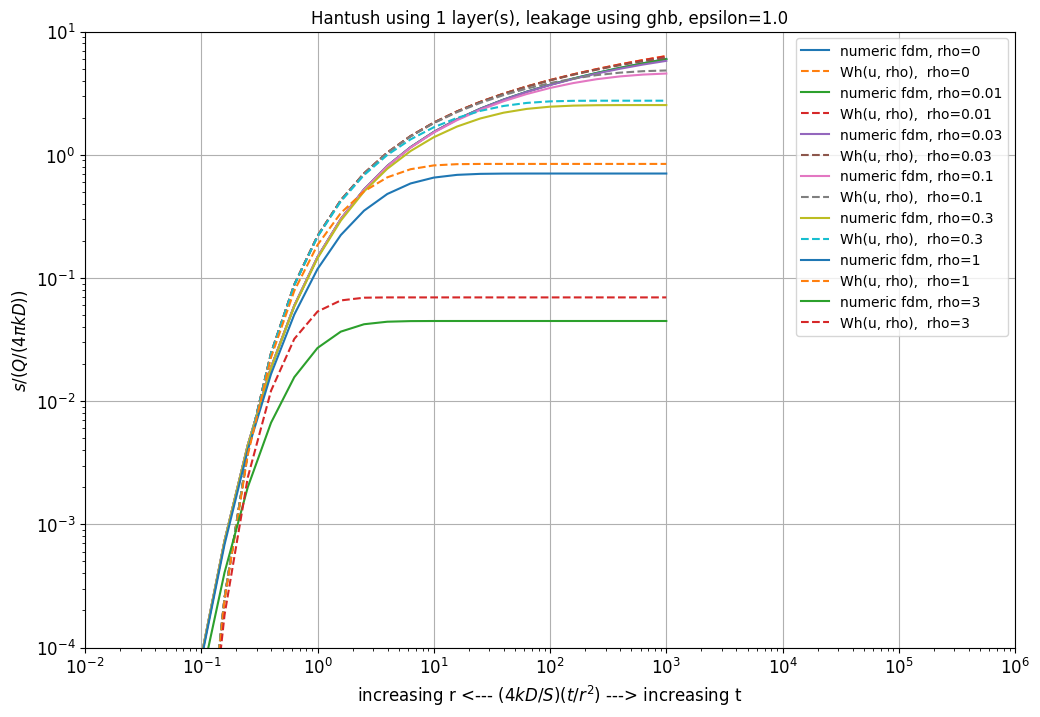

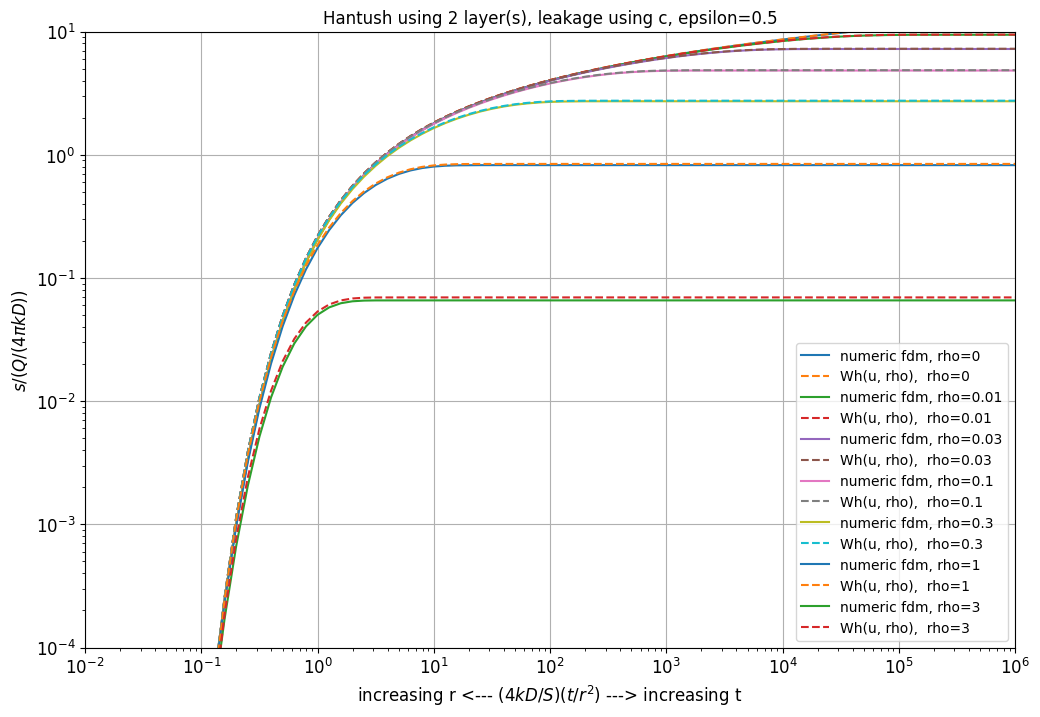

In [6]:
hantush(**Hantush1L) # for S=0 -> steady De Glee
hantush(**Hantush2L)